# Identification of gene regulatory network from gene expression time-course data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("Assignment-gene-expression.csv",sep=";")
df.head()


,time,SWI5,CBF1,GAL4,GAL80,ASH1
0,0,0.0760,0.0419,0.0207,0.0225,0.1033
1,10,0.0186,0.0365,0.0122,0.0175,0.0462
2,20,0.0090,0.0514,0.0073,0.0165,0.0439
3,30,0.0117,0.0473,0.0079,0.0147,0.0371
4,40,0.0088,0.0482,0.0084,0.0145,0.0475


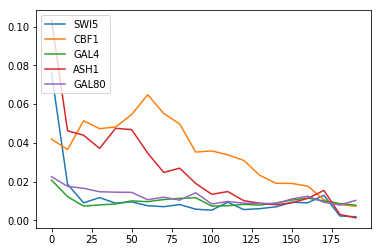

In [4]:
# Ploting the datas
t = df["time"]
plt.plot(t,df['SWI5'],label='SWI5')
plt.plot(t,df['CBF1'],label='CBF1')
plt.plot(t,df['GAL4'],label='GAL4')
plt.plot(t,df['ASH1'],label='ASH1')
plt.plot(t,df['GAL80'],label='GAL80')


plt.legend(loc='upper left')

# Linear regression model

In [5]:
# Compute finite differences for each gene

def finite_diff(x,y,dt):
    return (y-x)/dt

df_finite_diff_col = ['dSWI5','dCBF1','dGAL4','dGAL80','dASH1']
df_finite_diff = pd.DataFrame(np.zeros(shape=(len(df['time']),5)),columns=df_finite_diff_col)

for k in range(1,6):
    for i in range(len(df['time'])-1):
        df_finite_diff.iloc[i,k-1] = finite_diff(df.iloc[i,k],df.iloc[i+1,k],1)

df_finite_diff.head()

,dSWI5,dCBF1,dGAL4,dGAL80,dASH1
0,-0.0574,-0.0054,-0.0085,-0.0050,-0.0571
1,-0.0096,0.0149,-0.0049,-0.0010,-0.0023
2,0.0027,-0.0041,0.0006,-0.0018,-0.0068
3,-0.0029,0.0009,0.0005,-0.0002,0.0104
4,0.0007,0.0064,0.0016,-0.0001,-0.0007
5,-0.0020,0.0102,-0.0004,-0.0038,-0.0121
6,-0.0005,-0.0096,0.0011,0.0013,-0.0100
7,0.0011,-0.0055,0.0006,-0.0015,0.0022
8,-0.0024,-0.0145,0.0003,0.0038,-0.0079
9,-0.0005,0.0006,-0.0043,-0.0058,-0.0056
